# Qctrl optimization of pulse with finite blockade strength and nonzero NNN interactions
## optimization over:
### - phase
### - atom distance
### - Blockade interaction distance decay exponent
### - duration  
### - TODO: explore different pulse shapes or constant detuning/phase/amplitude, try gaussian pulses

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qctrlvisualizer as qv
import boulderopal as bo
plt.style.use(qv.get_qctrl_style())
controls_for_plots = lambda opt: {
    '$\\Delta$': opt['output']['delta'],
    '$\\Omega$': opt['output']['omega'],
    '$\\Phi$': opt['output']['phi']
}

Boulder Opal client update available.
Latest version is 1.4.0, you have 1.3.2.
Visit https://docs.q-ctrl.com/boulder-opal/changelog for the latest product updates.


In [2]:
# Dictionary for 27x27 Hamiltonian indexing
Hidx27 ={}
Hidx27['000'] = 0
Hidx27['100'] = 1
Hidx27['r00'] = 2
Hidx27['001'] = 3
Hidx27['00r'] = 4
Hidx27['101'] = 5
Hidx27['r01'] = 6
Hidx27['10r'] = 7
Hidx27['r0r'] = 8
Hidx27['010'] = 9
Hidx27['0r0'] = 10
Hidx27['110'] = 11
Hidx27['1r0'] = 12
Hidx27['r10'] = 13
Hidx27['rr0'] = 14
Hidx27['011'] = 15
Hidx27['0r1'] = 16
Hidx27['01r'] = 17
Hidx27['0rr'] = 18
Hidx27['111'] = 19
Hidx27['1r1'] = 20
Hidx27['r11'] = 21
Hidx27['11r'] = 22
Hidx27['r1r'] = 23
Hidx27['rr1'] = 24
Hidx27['1rr'] = 25
Hidx27['rrr'] = 26


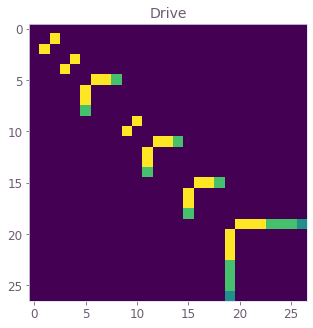

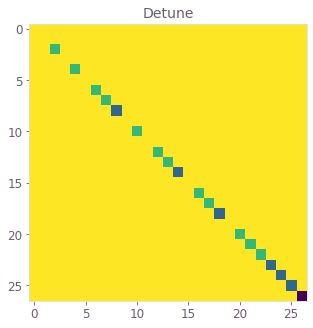

In [3]:
# Components for the drive operator.
drive_operator = np.zeros((27, 27))
# Components for the detuning operator.
detuneDiag = np.zeros(27)

# |000>	—>	####
# |100>	—>	A / sqrt2 (r00) 
drive_operator[Hidx27['100'], Hidx27['r00']] = np.sqrt(2)

# |r00>	—>	A* /  sqrt2 (100)     +   delta (r00)
drive_operator[Hidx27['r00'], Hidx27['100']] = np.sqrt(2)
detuneDiag[Hidx27['r00']] = -1

# |001>	—>	A/ sqrt2 (00r)
drive_operator[Hidx27['001'], Hidx27['00r']] = np.sqrt(2)

# |00r>	—>	A* / sqrt2 (001)  +   delta (00r)
drive_operator[Hidx27['00r'], Hidx27['001']] = np.sqrt(2)
detuneDiag[Hidx27['00r']] = -1

# |101>	—>	A / sqrt2 (r01) + A / sqrt2 (10r) + A / 2 (r0r)
drive_operator[Hidx27['101'], Hidx27['r01']] = np.sqrt(2)
drive_operator[Hidx27['101'], Hidx27['10r']] = np.sqrt(2)
drive_operator[Hidx27['101'], Hidx27['r0r']] = 1

# |r01>	—>	A* / sqrt2 (101) +   delta (r01)
drive_operator[Hidx27['r01'], Hidx27['101']] = np.sqrt(2)
detuneDiag[Hidx27['r01']] = -1

# |10r>	—>	A* / sqrt2 (101)  +   delta (10r)
drive_operator[Hidx27['10r'], Hidx27['101']] = np.sqrt(2)
detuneDiag[Hidx27['10r']] = -1

# |r0r>	—>	A* / 2 (101) +   2 delta (r0r) + nnn( r0r)
drive_operator[Hidx27['r0r'], Hidx27['101']] = 1
detuneDiag[Hidx27['r0r']] = -2

# —-----------------------------------
# |010>	—>	A / sqrt2 (0r0) 
drive_operator[Hidx27['010'], Hidx27['0r0']] = np.sqrt(2)

# |0r0>	—>	A* /  sqrt2 (010)     +   delta (0r0)
drive_operator[Hidx27['0r0'], Hidx27['010']] = np.sqrt(2)
detuneDiag[Hidx27['0r0']] = -1

# |110>	—>	A / sqrt2 (r10) + A / sqrt2 (1r0) 
drive_operator[Hidx27['110'], Hidx27['r10']] = np.sqrt(2)
drive_operator[Hidx27['110'], Hidx27['1r0']] = np.sqrt(2)

drive_operator[Hidx27['110'], Hidx27['rr0']] = 1


# |1r0>	—>	A* /  sqrt2 (110)     +   delta (1r0)
drive_operator[Hidx27['1r0'], Hidx27['110']] = np.sqrt(2)
detuneDiag[Hidx27['1r0']] = -1

# |r10>	—>	A* /  sqrt2 (110)     +   delta (r10)
drive_operator[Hidx27['r10'], Hidx27['110']] = np.sqrt(2)
detuneDiag[Hidx27['r10']] = -1


# |rr0>	########## nn
drive_operator[Hidx27['rr0'], Hidx27['110']] = 1
detuneDiag[Hidx27['rr0']] = -2


# |011>	—>	A / sqrt2 (0r1) + A / sqrt2 (01r) 
drive_operator[Hidx27['011'], Hidx27['0r1']] = np.sqrt(2)
drive_operator[Hidx27['011'], Hidx27['01r']] = np.sqrt(2)

drive_operator[Hidx27['011'], Hidx27['0rr']] = 1


# |0r1>	—>	A* /  sqrt2 (011)     +   delta (0r1)
drive_operator[Hidx27['0r1'], Hidx27['011']] = np.sqrt(2)
detuneDiag[Hidx27['0r1']] = -1

# |01r>	—>	A* /  sqrt2 (011)     +   delta (01r)
drive_operator[Hidx27['01r'], Hidx27['011']] = np.sqrt(2)
detuneDiag[Hidx27['01r']] = -1


# |0rr>	########### nn
drive_operator[Hidx27['0rr'], Hidx27['011']] = 1
detuneDiag[Hidx27['0rr']] = -2


# —----------------------------------
# |111>	—>	A / sqrt2 (r11) + A / sqrt2 (1r1) + A / sqrt2 (11r) + A / 2 (r1r)
drive_operator[Hidx27['111'], Hidx27['r11']] = np.sqrt(2)
drive_operator[Hidx27['111'], Hidx27['1r1']] = np.sqrt(2)
drive_operator[Hidx27['111'], Hidx27['11r']] = np.sqrt(2)
drive_operator[Hidx27['111'], Hidx27['r1r']] = 1

drive_operator[Hidx27['111'], Hidx27['rr1']] = 1
drive_operator[Hidx27['111'], Hidx27['1rr']] = 1
drive_operator[Hidx27['111'], Hidx27['rrr']] = 1/np.sqrt(2)


# |1r1>	—>	A* / sqrt2 (111) +   delta (1r1)
drive_operator[Hidx27['1r1'], Hidx27['111']] = np.sqrt(2)
detuneDiag[Hidx27['1r1']] = -1

# |r11>	—>	A* / sqrt2 (111) +   delta (r11)
drive_operator[Hidx27['r11'], Hidx27['111']] = np.sqrt(2)
detuneDiag[Hidx27['r11']] = -1

# |11r>	—>	A* / sqrt2 (111) +   delta (11r)
drive_operator[Hidx27['11r'], Hidx27['111']] = np.sqrt(2)
detuneDiag[Hidx27['11r']] = -1

# |r1r>	—>	A* / 2 (111) +  2*delta (r1r) + nnn
drive_operator[Hidx27['r1r'], Hidx27['111']] = 1
detuneDiag[Hidx27['r1r']] = -2

# |rr1>	########## nn
drive_operator[Hidx27['rr1'], Hidx27['111']] = 1
detuneDiag[Hidx27['rr1']] = -2

# |1rr>	#########	nn
drive_operator[Hidx27['1rr'], Hidx27['111']] = 1
detuneDiag[Hidx27['1rr']] = -2

# |rrr>	########### nnn + 2 nn
drive_operator[Hidx27['rrr'], Hidx27['111']] = 1/np.sqrt(2)
detuneDiag[Hidx27['rrr']] = -3

detuning_operator = np.diag(detuneDiag)

plt.imshow(drive_operator)
plt.title("Drive")
plt.show()
plt.imshow(detuning_operator)
plt.title("Detune")
plt.show()

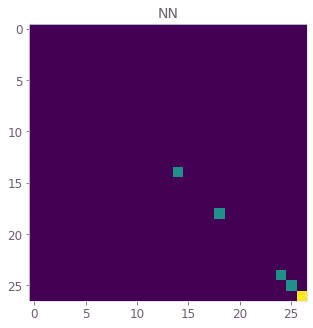

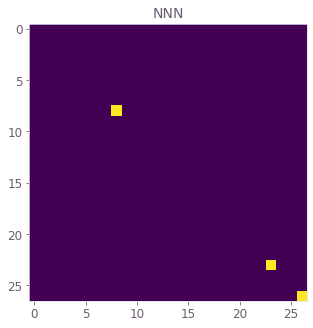

In [4]:
# Set parameters.
omega_max = 5 * 2 * np.pi * 1e6 # rad/s
delta_max = omega_max

# Components for the CCZ operator.
cz_0 = np.zeros(27)
cz_0[0] = 1
cz_0 = np.diag(cz_0)

cz_1 = np.zeros(27)
cz_1[[Hidx27['100'],Hidx27['010'],Hidx27['001']]] = 1
cz_1 = np.diag(cz_1)

cz_11 = np.zeros(27)
cz_11[[Hidx27['110'],Hidx27['101'],Hidx27['011']]] = 1
cz_11 = np.diag(cz_11)

cz_111 = np.zeros(27)
cz_111[Hidx27['111']] = 1
cz_111 = np.diag(cz_111)

# Blockade interactions

Blockade = 50 * 2 * np.pi * 1e9 # 50 GHz * µm^6

# next nearest neighbor
blockN3 = np.zeros(27)
blockN3[[Hidx27['r0r'],Hidx27['r1r'],Hidx27['rrr']]] = Blockade/64
blockN3 = np.diag(blockN3)

# nearest neighbor
blockNN = np.zeros(27)
blockNN[[Hidx27['0rr'],Hidx27['1rr'],Hidx27['rr0'],Hidx27['rr1']]] = Blockade
blockNN[Hidx27['rrr']] = 2*Blockade
blockNN = np.diag(blockNN)
plt.imshow(blockNN)
plt.title("NN")
plt.show()
plt.imshow(blockN3)
plt.title("NNN")
plt.show()

In [10]:
tau =  1 # * 1e-6 # s  *** use 1 when optimizing duration
max_duration=5e-6 # 5 us
# Define the control.
segment_countz = [256,1,256] #drive, detune, rabi
smoothing = [True,False,True]  #drive, detune, rabi
sample_times = np.linspace(0, tau, 200)



graph = bo.Graph()

duration = graph.optimizable_scalar(lower_bound = 1e-9, upper_bound = max_duration)
duration.name = "duration"


# Real piece-wise constant signal representing the Rabi amplitude.
##################
uomega = (
    graph.real_optimizable_pwc_signal(
        segment_count = segment_countz[0], 
        duration = tau, 
        minimum = 0,
        maximum = omega_max,
        name = 'uomega'
    )
)
# Real piece-wise constant signal representing the detuning.
udelta = (
    graph.real_optimizable_pwc_signal(
        segment_count = segment_countz[1], 
        duration = tau, 
        minimum = 0,
        maximum = delta_max,
        name = 'udelta'
    )
)

# Real piece-wise constant signal representing the Rabi phase.
uphi = (
    graph.real_optimizable_pwc_signal(
        segment_count = segment_countz[2], 
        duration = tau, 
        minimum = 0,
        maximum = 2 * np.pi, 
        name = 'uphi'
    )
)

# Filter signals.
fomega = graph.filter_and_resample_pwc(
    pwc=uomega,
    kernel=graph.sinc_convolution_kernel(omega_max*max_duration/2),
    segment_count=segment_countz[0],
    name="fomega",
)
fdelta = graph.filter_and_resample_pwc(
    pwc=udelta,
    kernel=graph.sinc_convolution_kernel(delta_max*max_duration/2),
    segment_count=segment_countz[1],
    name="fdelta",
)
fphi = graph.filter_and_resample_pwc(
    pwc=uphi,
    #kernel=graph.sinc_convolution_kernel(2 * np.pi * max_duration/2),
    kernel=graph.sinc_convolution_kernel(omega_max * max_duration/2),
    segment_count=segment_countz[2],
    name="fphi",
)

# Modulate signal with envelope.
env_omega = graph.signals.cosine_pulse_pwc(
    duration=tau, segment_count=segment_countz[0], amplitude=1.0
)

env_delta = graph.signals.cosine_pulse_pwc(
    duration=tau, segment_count=segment_countz[1], amplitude=1.0
)
env_phi = graph.signals.cosine_pulse_pwc(
    duration=tau, segment_count=segment_countz[2], amplitude=1.0
)

if smoothing[0]:
    omega = env_omega * fomega
else:
    omega = uomega
omega.name = "omega"

if smoothing[1]:
    delta = env_delta * fdelta
else:
    delta = udelta
delta.name = "delta"

if smoothing[2]:
    phi = env_phi * fphi
else:
    phi = uphi
phi.name = "phi"



# Real scalar signal representing the single qubit phase.
psi = (
    graph.optimizable_scalar(
        lower_bound = 0,
        upper_bound = 2 * np.pi, 
        name = 'psi'
    )
)


#atom distance (um)
r = (
    graph.optimizable_scalar(
        lower_bound = 3,
        upper_bound = 6, 
        name = 'r'
    )
)

#exponent
alpha = (
    graph.optimizable_scalar(
        lower_bound = 3,
        upper_bound = 6, 
        name = 'alpha'
    )
)


# Define the Hamiltonian.
hamiltonian = (
    graph.hermitian_part(omega * graph.exp(1j * phi) * drive_operator) + 
    delta * detuning_operator + r**(-alpha)*(blockNN+blockN3)
) * duration


# Define the target operator.
target = (
    graph.target(
        operator = (cz_0 +
            graph.exp(1j * psi) * cz_1 + 
            graph.exp(1j * 2 * psi) * cz_11 + 
            graph.exp(1j * (3 * psi + np.pi)) * cz_111
        )
    )
)

# Unitary time evolution.
unitary = (
    graph.time_evolution_operators_pwc(
        hamiltonian = hamiltonian, 
        sample_times = sample_times, 
        name = 'unitary'
    )
)

# Infidelity.
infidelity = (
    graph.infidelity_pwc(
        hamiltonian = hamiltonian,
        target = target,
        name = 'infidelity'
    )
)

# Cost function.
cost_function = (
    graph.sum(
        infidelity
    )
)
cost_function.name = 'cost_function'

In [11]:
result = (
    bo.run_optimization(
        graph = graph,
        cost_node_name = 'cost_function',
        output_node_names = [
            'omega', 
            'delta', 
            'phi', 
            'psi', 
            'unitary',
            'infidelity'
            ,'r'
            ,'duration'
            ,'alpha'
        ]
    )
)

Your task (action_id="1988780") has started.
Your task (action_id="1988780") has completed.


In [12]:
eta = result['output']['delta']['values'][0] / result['output']['omega']['values'][0]
#xi = np.abs(result['output']['phi']['values'][0] - result['output']['phi']['values'][1])
omegatau = result['output']['omega']['values'][0] * tau / 2

print(f"Infidelity: {result['output']['infidelity']['value']:.3e}")
print(f"Gate time: {omegatau}")
print(f"Ratio of detuning and Rabi frequncy: {eta}")
#print(f"Phase jump: {xi}")
#print(f"Equivalent phase jump: {2 * np.pi - xi}")
print(f"Single qubit phase: {result['output']['psi']['value']}")
print(f"Radius: {result['output']['r']['value']}")
print(f"Duration: {result['output']['duration']['value']}")
print(f"Exponent: {result['output']['alpha']['value']}")

Infidelity: 4.723e-06
Gate time: 131.55633375544596
Ratio of detuning and Rabi frequncy: 83350.57807372407
Single qubit phase: 3.804122652884425
Radius: 4.8277352068214565
Duration: 4.9093003288447986e-06
Exponent: 5.657281868460741


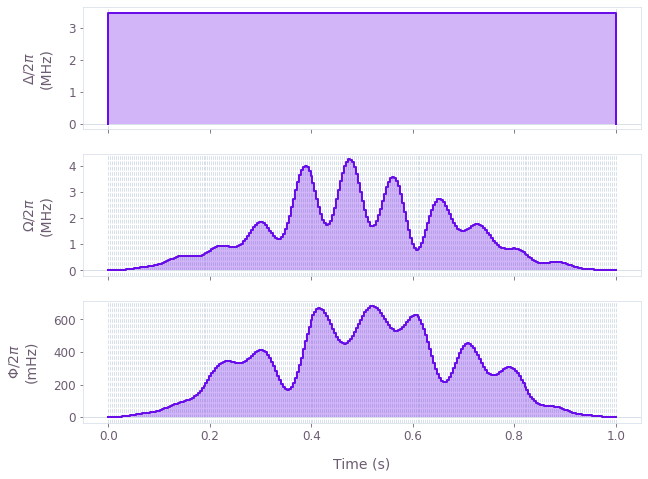

In [13]:
qv.plot_controls(controls_for_plots(result))

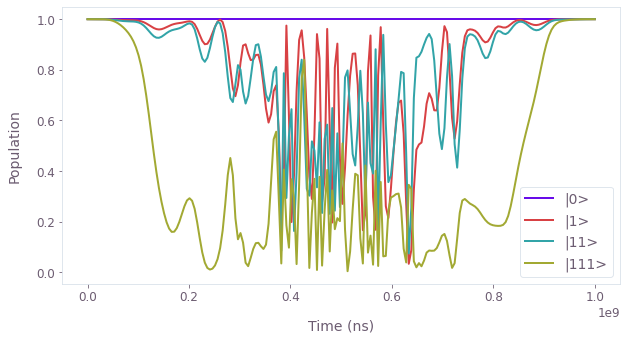

In [14]:
u = result['output']['unitary']['value']
# basis_labels = ["0", "01", "0r", "1-10", "1-r0z", "111", "r11z", "r1r", "1r1"]
psi0 = np.zeros(27)
psi0[Hidx27['000']] = 1
out0 = np.abs(np.transpose(psi0) @ u @ psi0)**2
psi1 = np.zeros(27)
psi1[Hidx27['100']] = 1
out1 = np.abs(np.transpose(psi1) @ u @ psi1)**2
psi11 = np.zeros(27)
psi11[Hidx27['101']] = 1
out11 = np.abs(np.transpose(psi11) @ u @ psi11)**2
psi111 = np.zeros(27)
psi111[Hidx27['111']] = 1
out111 = np.abs(np.transpose(psi111) @ u @ psi111)**2
plt.plot(1e9 * sample_times, out0)
plt.plot(1e9 * sample_times, out1)
plt.plot(1e9 * sample_times, out11)
plt.plot(1e9 * sample_times, out111)
plt.xlabel('Time (ns)')
plt.ylabel('Population')
plt.legend(['|0>','|1>','|11>','|111>'])